<a href="https://colab.research.google.com/github/nuyhc/RhythmStudy/blob/main/1.%20PyTorch/PTM_3_%EB%B0%95%EC%A7%80%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [PTM] 6장. 신경망을 활용한 데이터 적합

In [1]:
!git clone https://github.com/deep-learning-with-pytorch/dlwpt-code

fatal: destination path 'dlwpt-code' already exists and is not an empty directory.


In [2]:
# 데이터 수집
import torch

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

print(t_u.shape)
t_c, t_u

torch.Size([11, 1])


(tensor([[ 0.5000],
         [14.0000],
         [15.0000],
         [28.0000],
         [11.0000],
         [ 8.0000],
         [ 3.0000],
         [-4.0000],
         [ 6.0000],
         [13.0000],
         [21.0000]]), tensor([[35.7000],
         [55.9000],
         [58.2000],
         [81.9000],
         [56.3000],
         [48.9000],
         [33.9000],
         [21.8000],
         [48.4000],
         [60.4000],
         [68.4000]]))

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 2,  4,  3,  9,  8,  7,  0,  5, 10]), tensor([6, 1]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

### 파이토치 nn 모듈
forward 대신 __call__ 사용하기
* 파이토치가 제공하는 nn.Module의 모든 서브클래스에는 __call__ 메소드가 정의되어 있다. 이를 통해 nn.Linear를 인스턴스화하여 마치 함수인 것처럼 실행할 수 있다.

nn.Linear
* `nn.Linear`은 세 개의 인자를 갖는다. 입력 피처의 수, 출력 피처의 수, 선형 모델이 편향값을 포함하는지 여부이다.

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)  # 피처 수는 모듈에 대한 입출력 텐서 크기와 같아서, 값이 각각 1, 1이다.
linear_model(t_un_val)

tensor([[1.8071],
        [3.2039]], grad_fn=<AddmmBackward0>)

하나의 입력 피처와 출력 피처를 가진 nn.Linear 인스턴스
* 이 인스턴스는 weight와 bias값을 요구한다.

In [6]:
display(linear_model.weight)
linear_model.bias

Parameter containing:
tensor([[0.6349]], requires_grad=True)

Parameter containing:
tensor([-0.3451], requires_grad=True)

In [7]:
# 입력값으로 모듈 호출
x = torch.ones(1)
linear_model(x)

tensor([0.2898], grad_fn=<AddBackward0>)

### 배치 입력 만들기
nn에 있는 모든 모듈은 한 번에 여러 입력을 가진 batch에 대한 출력을 만들도록 작성되었다. 
  
[아래 코드]
* 10개의 샘플에 대해 nn.Linear을 실행해야 한다고 가정해보자. B가 배치의 크기이고, Nin이 입력 피처의 크기라면 크기가 B X Nin인 입력 텐서를 만들고 모델로 실행하는 이다.

In [8]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.2898],
        [0.2898],
        [0.2898],
        [0.2898],
        [0.2898],
        [0.2898],
        [0.2898],
        [0.2898],
        [0.2898],
        [0.2898]], grad_fn=<AddmmBackward0>)

### 배치 최적화
배치를 수행하는 이유
* 주요 이유 중 하나는 연산량을 충분히 크게 만들어 준비한 자원을 최대한 활용하기 위함이다.

In [9]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

학습 코드 업데이트
* 작성한 모델을 nn.Linear(1, 1)로 바꾼 후 옵티마이저에 선형 모델 파라미터 전달

In [10]:
import torch.optim as optim

linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),  # [params] 대신 넣은 것  
    lr = 1e-2
)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x7fb801639c80>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.5870]], requires_grad=True), Parameter containing:
 tensor([-0.3890], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training Loss {loss_train.item():.4f},',
                  f'Validation Loss {loss_val.item():.4f}')

In [14]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),  # 이제 직접 만든 손실 함수는 사용하지 않는다.
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training Loss 180.3538, Validation Loss 86.9997
Epoch 1000, Training Loss 3.7106, Validation Loss 2.0418
Epoch 2000, Training Loss 2.7230, Validation Loss 4.4909
Epoch 3000, Training Loss 2.6910, Validation Loss 5.0785

Parameter containing:
tensor([[5.5009]], requires_grad=True)
Parameter containing:
tensor([-18.3843], requires_grad=True)


### 신경망
선형 모델 대신 신경망을 근사 함수로 사용하도록 바꿔보자

* nn은 nn.Sequential 컨테이너를 통해 모듈을 간단하게 결합시켜준다.  

아래 모델은 한 개의 입력 피처로부터 13개의 은닉된 피처로 펼쳐지며, 결과값을 tanh 활성 함수로 넘겨서 결과로 나운 13개의 숫자를 하나의 출력 피처로 만들기 위해 선형적으로 결합한다. 

In [15]:
seq_model = nn.Sequential(
            nn.Linear(1, 13),
            nn.Tanh(),
            nn.Linear(13, 1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

파라미터 살펴보기

In [16]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

여러 개의 서브 모듈로 만들어진 모델의 파라미터를 추적할 경우, 파라미터를 이름으로 식별가능하게 하면 매우 편리하다.

In [17]:
# named_parameters
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


Sequential은 OrderedDict라는 인자를 받는데, 여기에 각 모듈의 이름을 정해서 전달할 수 있다.

In [18]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([  # 연속적인 경로를 만들어낸다는 점에서 Sequential이라는 이름이 매우 적절함
            ('hidden_linear', nn.Linear(1, 8)),
            ('hidden_activation', nn.Tanh()),
            ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
for name, param in seq_model.named_parameters():
    print(name, param)

hidden_linear.weight Parameter containing:
tensor([[-0.0029],
        [ 0.8202],
        [ 0.3619],
        [ 0.0901],
        [-0.6690],
        [ 0.1355],
        [-0.3344],
        [-0.9977]], requires_grad=True)
hidden_linear.bias Parameter containing:
tensor([-0.2240,  0.3410,  0.2266,  0.7364,  0.4984, -0.7426,  0.3408,  0.4178],
       requires_grad=True)
output_linear.weight Parameter containing:
tensor([[-0.0196,  0.2961,  0.3079, -0.0930,  0.0606, -0.1258, -0.1089, -0.1359]],
       requires_grad=True)
output_linear.bias Parameter containing:
tensor([0.0692], requires_grad=True)


In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


서브 모듈을 속성처럼 사용해 특정 Parameter에 접근할 수 있다.

In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0692], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training Loss 190.3055, Validation Loss 90.0991
Epoch 1000, Training Loss 11.7071, Validation Loss 3.2648
Epoch 2000, Training Loss 3.6821, Validation Loss 3.8625
Epoch 3000, Training Loss 1.6521, Validation Loss 5.2906
Epoch 4000, Training Loss 1.0967, Validation Loss 6.6690
Epoch 5000, Training Loss 0.9829, Validation Loss 7.6898
output tensor([[-0.0254],
        [11.4397]], grad_fn=<AddmmBackward0>)
answer tensor([[ 3.],
        [14.]])
hidden tensor([[-0.1924],
        [ 0.0053],
        [ 0.7105],
        [ 0.0108],
        [-0.7047],
        [-0.0098],
        [-0.7197],
        [-0.4822]])


### 선형 모델과 비교하기

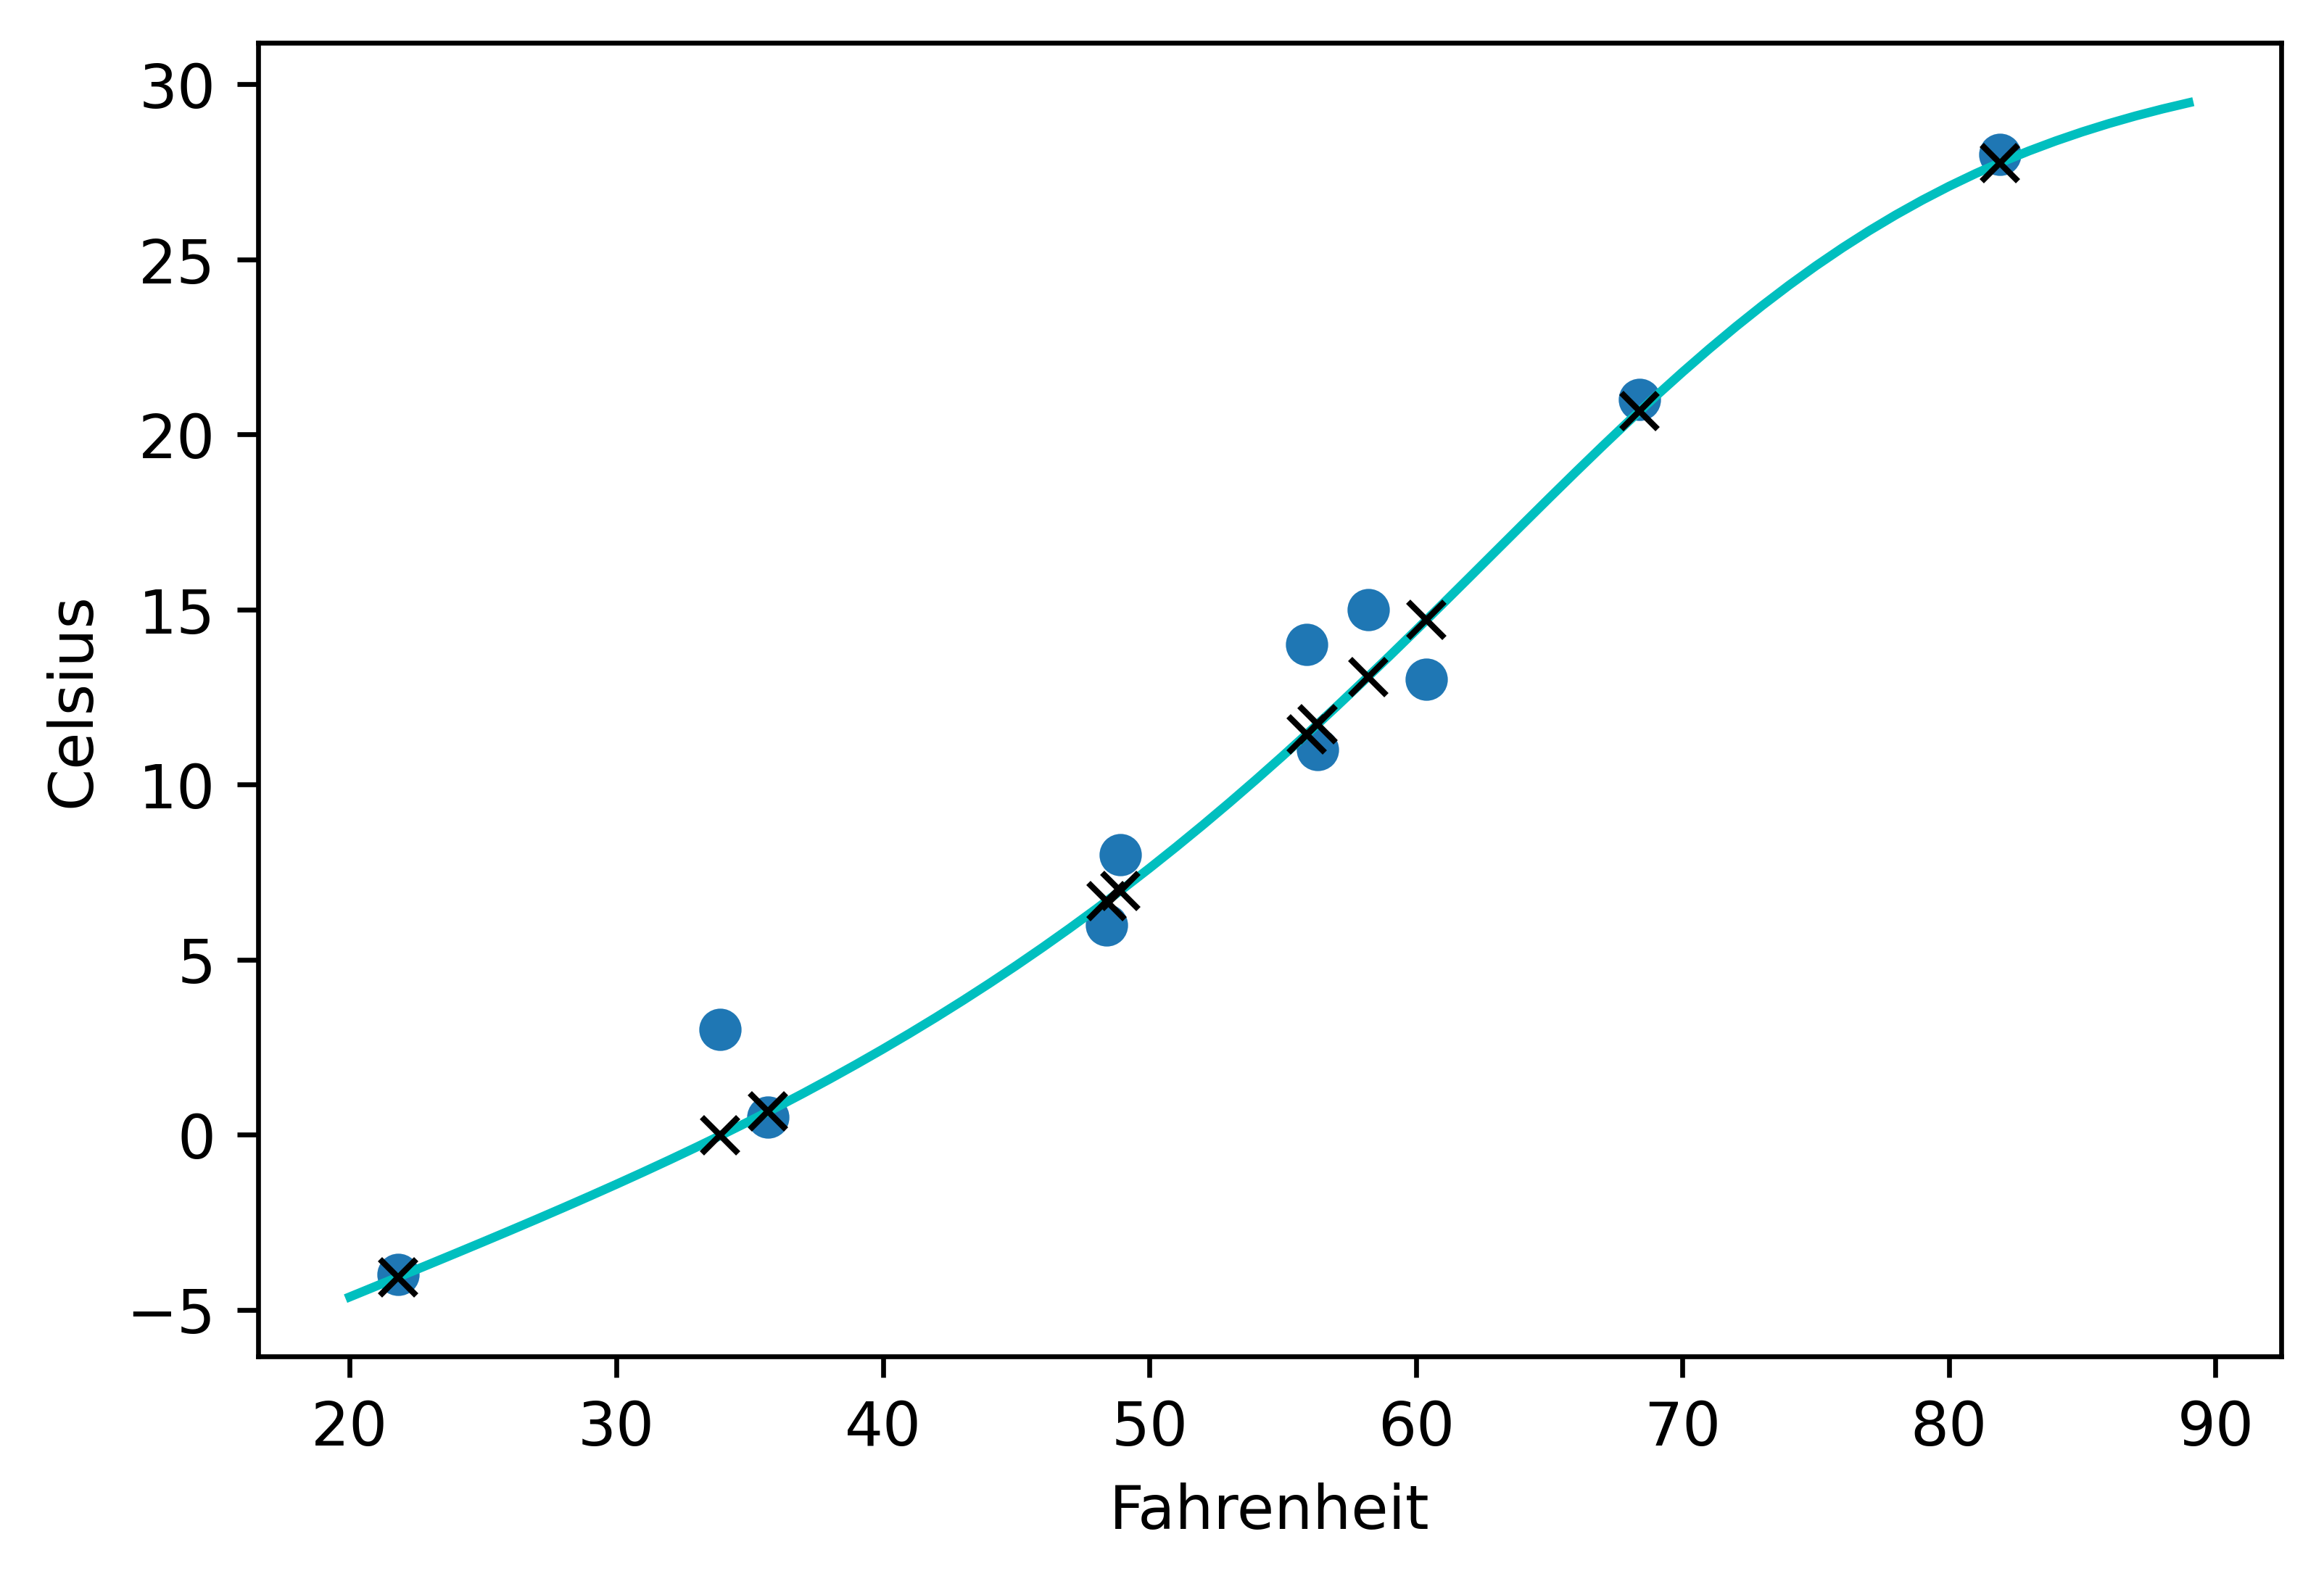

In [23]:
import matplotlib.pyplot as plt

t_range = torch.arange(20. , 90. ).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')  # 입력 데이터
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(),'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')  # 신경망 모델 그래프

plt.show()

# [PTM] 7장. 새와 비행기 구별하기: 이미지 학습

CIFAR-10 다운로드
* 32 x 32 크기의 컬러(RGB) 이미지 6만 개로 구성되어 있고 1에서 10까지의 정수로 레이블이 매겨져 있다. 0은 비행기, 1은 자동차, 2는 새, 3은 고양이, 4는 사슴, 5는 강아지, 6은 개구리. 7은 말, 8은 배, 9는 트럭이다.

In [24]:
from torchvision import datasets
data_path = '/content/dlwpt-code/p1ch7'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


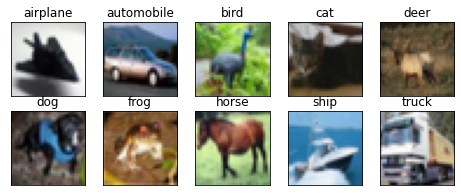

In [25]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

데이터셋은 `torch.utils.data.dataset.Dataset`의 서브클래스로 반환된다. cifar10 인스턴스의 메소드를 분석해보면 기본 클래스로 포함된 것을 알 수 있다.

In [26]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

파이토치 Dataset 객체 개념: 데이터를 직접 들고 있지는 않지만 `__len__`과 `__getitem__`을 통해 일관적으로 접근할 수 있게 해준다.

In [27]:
display(cifar10.__len__)
len(cifar10)

<bound method CIFAR10.__len__ of Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/dlwpt-code/p1ch7
    Split: Train>

50000

In [28]:
display(cifar10.__getitem__)
cifar10[4]

<bound method CIFAR10.__getitem__ of Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/dlwpt-code/p1ch7
    Split: Train>

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FB8015D4340>, 1)

### 데이터셋 클래스

In [29]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FB7F6E03550>,
 1,
 'automobile')

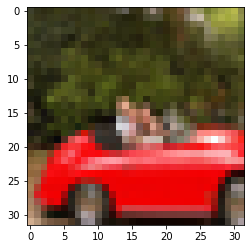

In [30]:
plt.imshow(img)
plt.show()

### 데이터 변환

In [31]:
from torchvision import transforms
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

torchvision의 transforms에서 ToTensor 메서드로 넘파이 배열, 이미지를 텐서로 만들기

In [32]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

transforms에서 ToTensor 메서드로 변환 자체를 dataset.CIFAR10의 인자로 전달하기 

In [33]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
tensor_cifar10

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/dlwpt-code/p1ch7
    Split: Train
    StandardTransform
Transform: ToTensor()

In [34]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [35]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

원본 `PIL 이미지` 값은 `0에서 255(채널당 8비트)` 범위인 반면 `ToTensor 변환`으로 데이터가 `채널당 32비트 부동소수점 형태`가 되면서 값이 `0.0`에서 `1.0` 사이로 범위가 줄어든다.

In [36]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

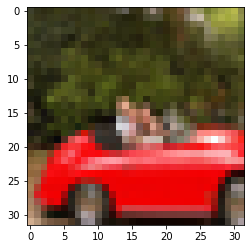

In [37]:
# matplotlib에서는 permute로 H X W X C 형태로 바꿈
plt.imshow(img_t.permute(1, 2, 0))  # C X H X W를 H X W X C로 바꿔준다.
plt.show()

### 데이터 정규화

데이터셋 정규화로 각 채널이 평균값 0과 단위 표준 편차를 만드는 연습을 해보자.  
평균값 0과 단위 표준 편차가 필요한 이유
* -1, 1 혹은 -2, 2 사이에서 선형인 활성 함수를 택하고 데이터를 같은 범위에서 평균을 가지게 된다면 뉴런은 0이 아닌 기울기를 가지게 되므로 빨리 학습할 수 있다.
* 각 채널을 정규화해 동일한 분산을 가지게 된다면 채널 정보가 동일한 학습률로 경사 하강을 통해 섞이고 업데이트되는 것을 보장할 수 있다.


In [38]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [39]:
imgs[0]

tensor([[[0.2314, 0.6039, 1.0000,  ..., 0.1373, 0.7412, 0.8980],
         [0.1686, 0.4941, 0.9922,  ..., 0.1569, 0.7294, 0.9255],
         [0.1961, 0.4118, 0.9922,  ..., 0.1647, 0.7255, 0.9176],
         ...,
         [0.6196, 0.3569, 0.9922,  ..., 0.3882, 0.6863, 0.8510],
         [0.5961, 0.3412, 0.9922,  ..., 0.3098, 0.6745, 0.8667],
         [0.5804, 0.3098, 0.9922,  ..., 0.3490, 0.6627, 0.8706]],

        [[0.0627, 0.5490, 1.0000,  ..., 0.2235, 0.7608, 0.8706],
         [0.0000, 0.5686, 1.0000,  ..., 0.1725, 0.7490, 0.9373],
         [0.0706, 0.4902, 1.0000,  ..., 0.1961, 0.7451, 0.9137],
         ...,
         [0.4824, 0.3765, 1.0000,  ..., 0.6118, 0.6784, 0.8745],
         [0.4667, 0.3020, 1.0000,  ..., 0.5529, 0.6706, 0.8902],
         [0.4784, 0.2784, 1.0000,  ..., 0.4549, 0.6549, 0.8235]],

        [[0.0980, 0.5490, 1.0000,  ..., 0.3843, 0.8157, 0.8353],
         [0.0627, 0.5451, 0.9961,  ..., 0.2510, 0.8039, 0.9176],
         [0.1922, 0.4510, 0.9961,  ..., 0.2706, 0.8000, 0.

view(3, -1)
* view(3, -1)은 세 채널은 유지하고 나머지 차원을 적절한 크기 하나로 합친다. 그래서 `3 X 32 X 32 이미지`는 `3 X 1,024 벡터`로 바뀌고 평균은 각 채널의 1,024개 요소에 대해 계산하는 것이다.

In [40]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [41]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [42]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [43]:
transforms_cifar10 = datasets.CIFAR10(
                     data_path, train = True, download = True,
                     transform = transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                              (0.2470, 0.2435, 0.2616))
                     ]))

Files already downloaded and verified


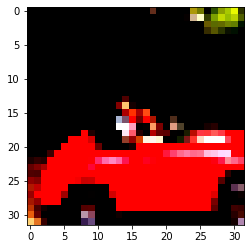

tensor([[[-1.0051, -1.1956, -1.2591,  ...,  0.6620,  0.9160,  0.1856],
         [-0.9892, -1.1163, -1.1639,  ...,  0.5984,  0.7255,  0.3127],
         [-1.0686, -0.9734, -1.1004,  ...,  0.4397,  0.3920, -0.0366],
         ...,
         [ 0.7413,  0.2809,  0.0745,  ..., -0.4971,  0.2492,  0.2174],
         [ 0.9160,  0.3920, -0.7193,  ..., -0.7035,  0.1539,  0.2809],
         [ 1.3288,  0.9001,  0.2174,  ..., -1.0527,  0.0745,  0.6937]],

        [[-0.9496, -1.1750, -1.2717,  ...,  0.7898,  0.9830,  0.2100],
         [-0.9335, -1.1267, -1.1750,  ...,  0.7415,  0.8220,  0.3710],
         [-0.9818, -0.9174, -1.0140,  ...,  0.5160,  0.4999,  0.0812],
         ...,
         [ 0.1939, -0.2087, -1.0784,  ..., -0.7724, -0.2409, -0.2893],
         [ 0.3710, -0.0799, -0.9496,  ..., -0.8207, -0.0799,  0.0328],
         [ 0.8220,  0.4516, -0.2248,  ..., -1.1106, -0.0638,  0.5321]],

        [[-1.0472, -1.3170, -1.4220,  ..., -0.6724, -0.5675, -0.6275],
         [-1.1521, -1.3170, -1.3021,  ..., -0

In [44]:
img_t, _ = transforms_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

img_t

### 새와 비행기 구별하기

### 데이터셋 구축
가장 먼저 할 일은 데이터의 차원 정보를 맞추는 일이다. 새와 비행기만 들어간 Dataset 서브 클래스를 만든다. 하지만 데이터셋은 작으며, 인덱싱과 len만 있으면 되기 때문에 굳이 torch.utils.data.dataset.Dataset의 서브클래스일 필요는 없다.

In [45]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
           for img, label in cifar10
           if label in (0, 2)]
cifar2_val = [(img, label_map[label])
               for img, label in cifar10_val
               if label in (0, 2)]

### 완전 연결 모델
샘플마다 피처는 얼마나 존재할까? 32 X 32 X 3이니까 샘플마다 3,072개의 입력 피처가 있는 셈이다. nn.Linear이면서 입력 피처가 3,072이고 몇 개의 히든 피처를 거처 활성 함수로 이어지도록 만들자, 이후 다른 nn,Linear로 신경망을 줄여나가면서 원하는 출력 피처 수로 맞추자

In [46]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072,  # 입력 피처
        512  # 은닉층 크기
    ),
    nn.Tanh(),
    nn.Linear(
        512,  # 은닉층 크기
        n_out  # 출력 클래스
    )
)

신경망은 최소 하나 이상의 비선형성을 가진 은닉층(활성 함수를 포함하므로 두 개의 모듈)이 필요하다. 임의의 함수를 학습할 수 있어야 하기 때문이다. 그렇지 않다면 단순 선형 모델에 불과할 뿐이다.

### 분류기의 출력
1. 출력값은 카테고리이다.
2. 이상적인 경우 신경만은 비행기에 대해 torch.tensor([1.0, 0.0])을 출력하고 새에 대해 torch.tensor([0.0, 1.0])을 출력한다.
3. 출력을 확률로 해석할 수 없다.

문제를 확률로 보게 될 경우 신경망의 출력에 추가적인 제약을 수반하는 것
* 출력값의 요소가 가질 수 있는 값은 [0.0, 1.0] 범위로 제한한다. (확률은 0보다 작거나 1보다 클 수 없으므로)
* 모든 출력 요소의 값의 합은 1.0이다. (결과는 항상 새 아니면 비행기라고 확신한다.)

이런 제약을 극복하면서 미분 가능하게 만드는 방법이 `소프트맥스softmax` 이다.

### 출력을 확률로 표현하기
소프트맥스는 벡터값을 받아 동일한 차원의 다른 벡터를 만드는데, 값이 확률로 표현되어야 하는 제약을 만족한다.  
소프트맥스는 벡터의 각 요소 단위로 지수 연산 후 각 요소를 지수 값의 총합으로 나눈다.

In [47]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [48]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [49]:
softmax(x).sum()

tensor(1.)

nn 모듈은 소프트맥스를 모듈처럼 사용할 수 있게 해준다. 통상적으로 입력 텐서는 0번 차원이 배치에 해당하거나 확률 값을 특정 차원에서만 인코딩해서 차원 수를 지정한다.

두 행에 두 개의 입력 벡터가 있고 차원 1을 따라 nn.Softmax가 동작하도록 초기화한다.

In [50]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

모델의 끝에 소프트맥스를 추가하여 신경망이 확률을 출력!

In [51]:
model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.Softmax(dim=1)
)

### 데이터 정규화
PIL 이미지 -> ToTensor() -> list로 출력 -> torch.stack()

In [52]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
list_cifar2 = [to_tensor(img) for img, _ in cifar2]
type(list_cifar2)

list

In [53]:
# list를 Tensor로 변경하기
# torch.stack()
tensor_cifar2 = torch.stack(list_cifar2, dim=0)
# imgs = torch.stack([img_t for img_t, _ in tensor_cifar2], dim=3)

In [54]:
type(tensor_cifar2)

torch.Tensor

In [55]:
tensor_cifar2.view(3, -1).mean(dim=1)

tensor([0.5142, 0.5112, 0.5144])

In [56]:
tensor_cifar2.view(3, -1).std(dim=1)

tensor([0.2505, 0.2469, 0.2456])

In [57]:
from torchvision import transforms
transforms = transforms.Normalize((0.5142, 0.5112, 0.5144), (0.2505, 0.2469, 0.2456))
transform_cifar2 = transforms(tensor_cifar2)
transform_cifar2

tensor([[[[ 5.1472e-01, -4.0892e-01, -2.0541e-01,  ..., -3.4630e-01,
           -3.6196e-01, -6.2809e-01],
          [ 5.6168e-01, -2.3672e-01, -9.2554e-01,  ..., -4.0892e-01,
           -4.0892e-01, -6.5940e-01],
          [ 1.3900e-01,  1.7031e-01, -1.8975e-01,  ..., -4.2458e-01,
           -7.3768e-01, -8.3161e-01],
          ...,
          [ 1.2335e-01,  1.7031e-01,  6.0726e-02,  ..., -6.5940e-01,
           -5.3416e-01, -8.0169e-02],
          [ 4.9906e-01,  3.4252e-01,  2.3293e-01,  ..., -7.2202e-01,
           -5.1851e-01, -6.4514e-02],
          [ 8.1216e-01,  7.0258e-01,  3.5817e-01,  ..., -5.8113e-01,
           -6.2809e-01, -1.4279e-01]],

         [[ 1.2015e+00,  1.5318e-01,  2.8024e-01,  ...,  2.6436e-01,
            2.6436e-01, -2.1538e-02],
          [ 1.3127e+00,  4.7084e-01, -3.3920e-01,  ...,  1.8494e-01,
            1.8494e-01, -5.3304e-02],
          [ 9.6322e-01,  9.9499e-01,  5.1849e-01,  ...,  1.3729e-01,
           -1.6449e-01, -2.4390e-01],
          ...,
     

In [58]:
transform_cifar2.__getitem__(10)[0].shape

torch.Size([32, 32])

In [59]:
transform_cifar2[0]

tensor([[[ 0.5147, -0.4089, -0.2054,  ..., -0.3463, -0.3620, -0.6281],
         [ 0.5617, -0.2367, -0.9255,  ..., -0.4089, -0.4089, -0.6594],
         [ 0.1390,  0.1703, -0.1898,  ..., -0.4246, -0.7377, -0.8316],
         ...,
         [ 0.1233,  0.1703,  0.0607,  ..., -0.6594, -0.5342, -0.0802],
         [ 0.4991,  0.3425,  0.2329,  ..., -0.7220, -0.5185, -0.0645],
         [ 0.8122,  0.7026,  0.3582,  ..., -0.5811, -0.6281, -0.1428]],

        [[ 1.2015,  0.1532,  0.2802,  ...,  0.2644,  0.2644, -0.0215],
         [ 1.3127,  0.4708, -0.3392,  ...,  0.1849,  0.1849, -0.0533],
         [ 0.9632,  0.9950,  0.5185,  ...,  0.1373, -0.1645, -0.2439],
         ...,
         [ 0.2802,  0.3914,  0.4073,  ...,  0.0579,  0.2802,  0.7250],
         [ 0.4232,  0.5344,  0.5344,  ..., -0.0057,  0.2802,  0.7567],
         [ 0.3597,  0.8203,  0.3755,  ...,  0.0579,  0.0420,  0.6297]],

        [[-0.7532, -1.1205, -0.4818,  ..., -0.9288, -0.9927, -1.1843],
         [-0.7532, -1.3121, -1.4079,  ..., -0

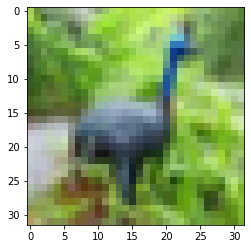

In [60]:
img, _ = cifar2[0]

plt.imshow(img)
plt.show()

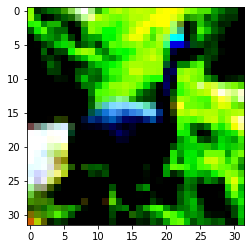

In [61]:
img = transform_cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [62]:
len(img)

3

In [63]:
img_batch = img.view(-1).unsqueeze(0)
out = model(img_batch)
out

tensor([[0.6233, 0.3767]], grad_fn=<SoftmaxBackward0>)

In [64]:
_, index = torch.max(out, dim=1)

index

tensor([0])

### 분류를 위한 손실값

1. 순방향 전달 후 마지막(선형) 계층에서 출력값을 얻는다.
2. 이들의 소프트맥스 값을 계산하여 확률을 얻는다.
3. (파라미터의 기능도에 해당하는) 정답 클래스와 일치하는 예측 확률값을 얻는다. 지도supervised 문제이기 때문에 실측값이 존재하므로, 정답 클래스를 안다고 가정할 수 있다.
4. 로그값을 계산해서 앞에 마이너스를 붙인 다음 손실값에 더한다.

In [65]:
from torch import nn

In [66]:
model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()

손실값은 배치에 대한 nn.LogSoftmax 출력을 첫 번째 인자로 받고 클래스 인덱스 텐서를 두 번째 인자로 받는다. 이제 새를 가지고 테스트해보자.

In [67]:
img_t = transform_cifar2[0]
img, label = cifar2[0]

out = model(img_t.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.6647, grad_fn=<NllLossBackward0>)

### 분류기 훈련

In [ ]:
import torch
import torch.nn as nn

model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img_t.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))  # 마지막 이미지의 손실값을 출력한다.

미니 배치에서 얻은 기울기를 사용하면 전체 데이터셋에 대한 값만큼 근사하지는 않지만 훈련 중에 만날지도 모르는 지역 최솟값에 최적화 프로세스가 빠져버리는 것을 예방하고 수렴을 돕는 것으로 알려져 있다. 미니 배치에서의 기울기는 이상적인 궤적에서 랜덤하게 떨어져 있따. 그래서 이 경우 작은 학습률을 사용한다. 
* 통상 미니 배치 크기는 학습률을 지정했던 것과 같이 훈련 전에 상수로 고정한다. 이와 같은 고정 값들은 모델의 파라미터와 구분하여 `하이퍼파라미터`라 부른다.
* torch.utils.data 모듈에는 미니 배치의 데이터를 섞거나 구조화하는 작업을 돕는 DataLoader 클래스가 있다.데이터 로더를 활용해 데이터셋에서 미니 배치에 포함될 샘플을 가져올 때 여러 가지 샘플링 전략 중에서 하나를 고를 수 있다. 가장 흔한 전략은 각 에포크마다 데이터를 섞은 후 고르게 샘플링하는 것이다.

In [69]:
# 데이터 로더
# batch_size = 4
# shuffle = True
# __next__
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

DataLoader는 순회 가능하기 때문에 새로운 훈련 코드의 루프 안에 바로 넣어 사용할 수 있다.

In [70]:
train_loader

In [ ]:
import torch
import torch.nn as nn

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
        nn.Linear(3072, 512),
        nn.Tanh(),
        nn.Linear(512, 2),
        nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, label in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

????

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

In [71]:
model = nn.Sequential(
        nn.Linear(3072, 1024),
        nn.Tanh(),
        nn.Linear(1024, 512),
        nn.Tanh(),
        nn.Linear(512, 128),
        nn.Tanh(),
        nn.Linear(128, 2),
        nn.LogSoftmax(dim=1))

nn.LogSoftmax와 nn.CrossEntropyLoss와 동일하다. nn.CrossEntropyLoss는 파이토치의 특징을 잘 나타내는 요소다. nn.NLLLoss는 크로스엔트로피를 계산하지만 입력으로 로그 확률 예측을 받는 반면, nn.CrossEntropyLoss는 점수를 입력으로 받는다.
* `nn.NLLLoss`는 타깃에 모든 것을 담아 넣는 디랙 분포와 로그 확률 입력으로 주어지는 예측 분포 사이의 `크로스엔트로피`라고 볼 수 있다.

In [72]:
model = nn.Sequential(
        nn.Linear(3072, 1024),
        nn.Tanh(),
        nn.Linear(1024, 512),
        nn.Tanh(),
        nn.Linear(512, 128),
        nn.Tanh(),
        nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

파이토치는 nn.Model의 parameters() 메소드를 통해 모델이 얼마나 많은 파라미터를 가지고 있는지를 빠르게 확인할 수 있다. 각 텐서 객체에 얼마나 많은 요소가 있는지 확인하려면 numel 메소드를 사용한다. 그리고 얻은 값을 합산하면 전체 수를 파악할 수 있다.

In [73]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [74]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [75]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

### 완전 연결의 한계